# Learning Graph Representations

## Network and Vertex feature joint representation learning

We aren't always simply working with only individual networks. We might have 
access to extra information about our networks, or 

<what is the problem vertex feature joint representation learning is trying to solve?>

In many network problems, you might have access to much more information than just the 
collection of nodes and edges in the network. If you were investigating a social 
network, for instance, you might have access to extra information about each 
person -- their gender, for instance, or their age. When we you embed a network, it seems 
like you should be able to use this information - called "features" or "covariates" - to somehow improve your analysis.
Many of the techniques and tools that we'll explore in this section use both the covariates and the network to 
learn from new, holistic representations of the data available to us, jointly using both the network and the covariates.
These techniques are called joint representation learning.

There are two primary reasons that we might want to explore using node covariates in addition to networks. Firstly, they might improve our 
standard embedding algorithms, like Laplacian and Adjacency Spectral Embedding. 
For example, if the latent structure of the covariates lines up with the latent structure
of our network, then we could conceivably reduce noise, even if they don't overlap perfectly. Second,
figuring out what the clusters of an embedding actually mean can sometimes be difficult, and using covariates
gives us to access to a natural structure. If we're clustering brain networks, for instance, 
covariate information telling us a location in the brain and name of brain region for each node might let us better
cluster by region.

<more stuff here, tbd>

#### Generating Data

Let's try making a network along with its covariates. First, let's generate a network using a Stochastic Block Model with 1500 nodes and 3 communities.

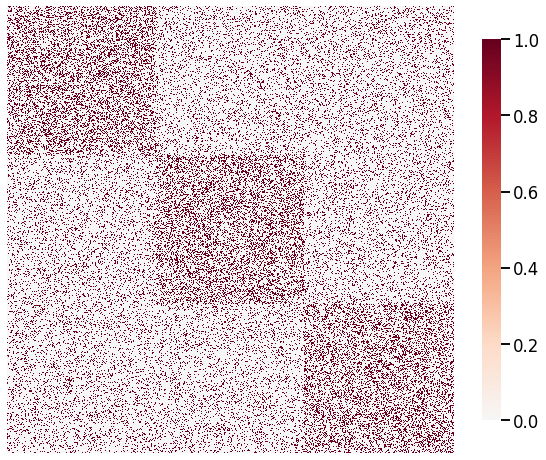

In [1]:
import numpy as np
from graspologic.simulations import sbm
from graspologic.plot import heatmap

# Start with some simple parameters
N = 1500
n = N // 3
p, q = .3, .15
B = np.array([[p, q, q],
              [q, p, q],
              [q, q, p]])

# Make our Stochastic Block Model
A, labels = sbm([n, n, n], B, return_labels = True)
heatmap(A);

Now, let's generate some covariates. Remember, each node is associated with its own vector of covariates that provide information about the node. We'll organize these into a matrix, where each row contains the covariates associated with a particular node.  

To keep things simple, we'll have our covariates only take on true/false values - or, more specifically, 0 and 1. We'd also like a node's covariates to look different depending on which community it belongs to. To that end, we'll give each node 30 covariates, with the first 10 having a higher probability of 1 in the first community, the second having a higher probability of 1 in the second community, and the third having a higher probability of 1 in the third community.

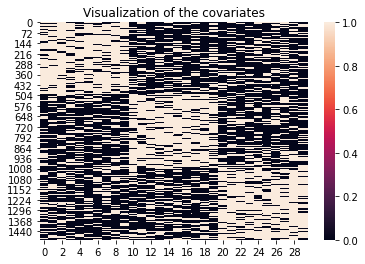

In [43]:
import numpy as np
from scipy.stats import bernoulli
import seaborn as sns

def gen_covariates(p1=.8, p2=.3, N=1500):
    """
    Generate a matrix of covariates.
    """
    n_covariates = 30

    bern = lambda p: bernoulli.rvs(p, size=(N//3, n_covariates//3))    
    X = np.block([[bern(p1), bern(p2), bern(p2)],
                  [bern(p2), bern(p1), bern(p2)],
                  [bern(p2), bern(p2), bern(p1)]])

    return X

X = gen_covariates(N=N)
ax = sns.heatmap(X)
ax.set_title("Visualization of the covariates");

### Covariate-Assisted Spectral Clustering

<AxesSubplot:title={'center':'Covariate matrix times itself'}>

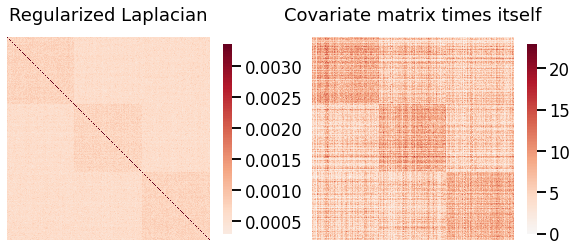

In [32]:
from graspologic.utils import to_laplacian
import matplotlib.pyplot as plt

L = to_laplacian(A)
LL = L@L
XXt = X@X.T

# plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
heatmap(LL, title=r"Regularized Laplacian", ax=axs[0])
heatmap(XXt, title="Covariate matrix times itself", ax=axs[1])

<AxesSubplot:title={'center':'Our Combined Laplacian and covariates matrix'}>

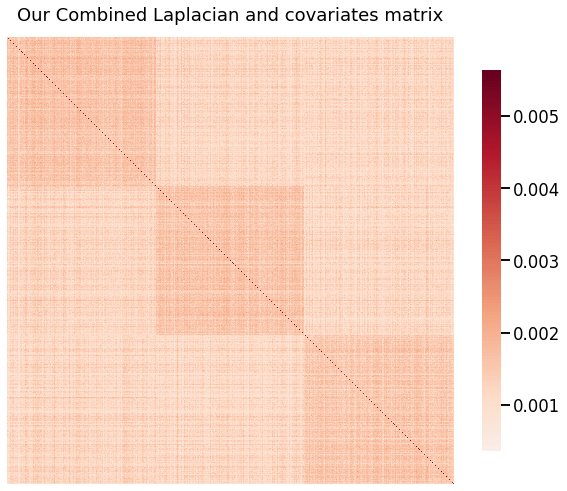

In [38]:
top_eigval_L = np.linalg.eigvalsh(LL)[-1]
top_eigval_XXt = np.linalg.eigvalsh(XXt)[-1]
alpha = np.float(top_eigval_L / top_eigval_XXt)

L_ = L@L + alpha * X@X.T
heatmap(L_, title="Our Combined Laplacian and covariates matrix")

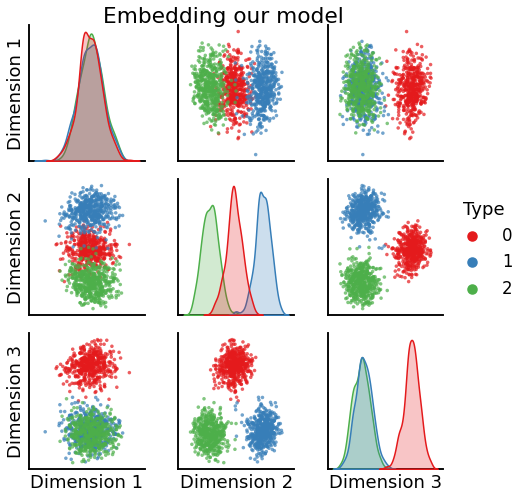

In [39]:
from graspologic.embed import selectSVD
from graspologic.plot import pairplot

U, D, V = selectSVD(L_, n_components=3, algorithm="full")
svd_plot = pairplot(U, labels=labels, title="Embedding our model")

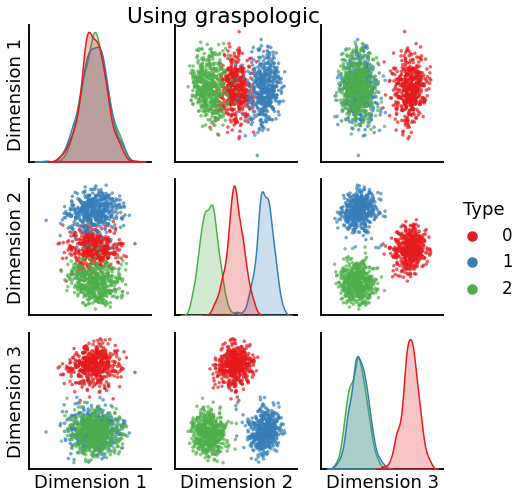

In [40]:
from graspologic.embed import CovariateAssistedEmbedding as CASE

casc = CASE(embedding_alg="non-assortative", n_components=3)
casc_plot = pairplot(casc.fit_transform(A, covariates=X), labels=labels, title="Using graspologic")